In [2]:
import torch
import torchvision.transforms as transforms
import pandas as pd
import torch.nn as nn
import os
import warnings
import numpy as np
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, alexnet, densenet121, resnet34
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
DEVICE = 'cuda:0'

In [3]:
class MyDataset(Dataset):
    
    def __init__(self, base_dir, csv_data, mode='train', choose=None):
        self.base_dir = base_dir
        self.data = csv_data
        self.mode = mode
        self.over_sample = SMOTE(random_state=0)
        self.choose = choose

        if mode == 'train':
            self.transform = transforms.Compose([
                transforms.ToPILImage(), 
                transforms.ToTensor(),
                transforms.Normalize((0.59685254, 0.59685254, 0.59685254), (0.16043035, 0.16043035, 0.16043035))
            ])
        else:
        
            self.transform = transforms.Compose([
                transforms.ToPILImage(), 
                transforms.ToTensor(),
                transforms.Normalize((0.59685254, 0.59685254, 0.59685254), (0.16043035, 0.16043035, 0.16043035))
            ])
        self.__preprocess_data()
        
    
    def __preprocess_data(self):
        if self.choose is None:
            image_paths = [os.path.join(self.base_dir, path) for path in self.data[0]]
            labels = [int(prob * 3) for prob in self.data[2]]
        else:
            image_paths = [os.path.join(self.base_dir, path) for idx, path in enumerate(self.data[0]) if self.data[19].iloc[idx] == self.choose]
            labels = [int(prob * 3) for idx, prob in enumerate(self.data[2]) if self.data[19].iloc[idx] == self.choose]
        if self.mode == 'train':
            resample_indices, _ = self.over_sample.fit_resample(np.array(range(len(labels))).reshape(-1, 1), labels)
        else:
            resample_indices = np.array(range(len(labels))).reshape(-1, 1)
        self.data = [(image_paths[idx.item()], labels[idx.item()]) for idx in resample_indices]
        
    def load_image(self, image_path):
        image = np.array(Image.open(image_path).convert('RGB'))
        image = self.transform(image)
        return image
    
    def __getitem__(self, idx):
        image_path, multi_label = self.data[idx]
        image = self.load_image(image_path)
        return image, multi_label
    
    def __len__(self):
        return len(self.data)
        
        
        

In [4]:
class MyModel(nn.Module):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.backbone = alexnet(pretrained=False)
        self.backbone.fc = nn.Sequential(nn.Linear(512, 4), nn.Softmax(dim=-1))
    
    
    def forward(self, inputs):
        outputs = self.backbone(inputs)
        return outputs
        

In [5]:
from tqdm import tqdm

def train_loop(train_dataloader, model, loss_fn, optimizer, epoch_num):
    truth = []
    preds = []
    avg_loss = 0.0
    step_num = 0
    pbar = tqdm(train_dataloader, desc=f'Epoch {epoch_num}')
    for images, multi_labels in pbar:
        images = images.to(DEVICE)
        multi_labels = multi_labels.to(DEVICE)
        optimizer.zero_grad()
        multi_outputs = model(images)
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()
        f1 = f1_score(truth, preds, average='macro')
        acc = accuracy_score(truth, preds)
        loss = loss_fn(multi_outputs, multi_labels)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        step_num += 1
        pbar.set_postfix(
        {'Train Loss': loss.item(),
         'Train Acc': acc,
         'Train F1': f1
        }
        )
    avg_loss /= step_num
    return avg_loss



def eval_loop(test_dataloader, model, loss_fn, epoch_num):
        with torch.no_grad():
            avg_loss = 0.0
            step_num = 0
            preds = []
            truth = []
            pbar = tqdm(test_dataloader, desc=f'Epoch {epoch_num}')
            for images, multi_labels in pbar:
                images = images.to(DEVICE)
                multi_labels = multi_labels.to(DEVICE)
                multi_outputs = model(images)
                multi_preds = torch.argmax(multi_outputs, dim=-1)
                preds += multi_preds.reshape(-1).tolist()
                truth += multi_labels.reshape(-1).tolist()
                f1 = f1_score(truth, preds, average='macro')
                acc = accuracy_score(truth, preds)
                loss = loss_fn(multi_outputs, multi_labels)
                avg_loss += loss.item()
                step_num += 1
                pbar.set_postfix(
                    {'Test Loss': loss.item(),
                     'Test Acc': acc,
                     'Test F1': f1
                    }
                    )
            avg_loss /= step_num
            return avg_loss


In [6]:
# train
label_path = '/kaggle/input/elpv-dataset-master/labels.csv'
image_dir = '/kaggle/input/elpv-dataset-master/images'

csv_data = pd.read_csv(label_path, sep=' ', header=None)
train_data, test_data = train_test_split(csv_data, test_size=0.25, random_state=0)
train_dataset = MyDataset(image_dir, train_data, 'train')
test_dataset = MyDataset(image_dir, test_data, 'test')
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model = MyModel().to(DEVICE)

lr = 0.001
epochs = 60

multi_loss = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 0.001) 


for epoch in range(epochs):
    train_loss = train_loop(train_dataloader, model, multi_loss, optimizer, epoch)
    test_loss = eval_loop(test_dataloader, model, multi_loss, epoch)
    print(f'Epoch {epoch} | Train loss {train_loss} | Test Loss {test_loss}')

Epoch 0: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s, Test Loss=0.519, Test Acc=0.64, Test F1=0.311] 


Epoch 0 | Train loss 2.728757091694408 | Test Loss 0.901473343372345


Epoch 1: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s, Test Loss=0.489, Test Acc=0.637, Test F1=0.33] 


Epoch 1 | Train loss 1.0282310644785564 | Test Loss 0.8960273961226145


Epoch 2: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s, Test Loss=0.481, Test Acc=0.659, Test F1=0.337]


Epoch 2 | Train loss 1.0069336940844853 | Test Loss 0.8671296834945679


Epoch 3: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s, Test Loss=0.492, Test Acc=0.651, Test F1=0.324]


Epoch 3 | Train loss 0.992539546555943 | Test Loss 0.8681825349728266


Epoch 4: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s, Test Loss=0.507, Test Acc=0.674, Test F1=0.375]


Epoch 4 | Train loss 0.9702487107780244 | Test Loss 0.8639853199323019


Epoch 5: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s, Test Loss=0.454, Test Acc=0.674, Test F1=0.375]


Epoch 5 | Train loss 0.945085186097357 | Test Loss 0.8312019258737564


Epoch 6: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s, Test Loss=0.629, Test Acc=0.645, Test F1=0.362]


Epoch 6 | Train loss 0.9414193828900655 | Test Loss 0.9714452425638834


Epoch 7: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s, Test Loss=0.476, Test Acc=0.694, Test F1=0.403]


Epoch 7 | Train loss 0.9407113807068931 | Test Loss 0.8284733990828196


Epoch 8: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s, Test Loss=0.427, Test Acc=0.674, Test F1=0.347]


Epoch 8 | Train loss 0.9149579389227761 | Test Loss 0.823805088798205


Epoch 9: 100%|██████████| 6/6 [00:02<00:00,  2.01it/s, Test Loss=0.549, Test Acc=0.68, Test F1=0.41]  


Epoch 9 | Train loss 0.9108435660600662 | Test Loss 0.8519267737865448


Epoch 10: 100%|██████████| 6/6 [00:02<00:00,  2.06it/s, Test Loss=0.494, Test Acc=0.684, Test F1=0.35] 


Epoch 10 | Train loss 0.8852673255734973 | Test Loss 0.822156697511673


Epoch 11: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s, Test Loss=0.646, Test Acc=0.66, Test F1=0.389] 


Epoch 11 | Train loss 0.8736841860744688 | Test Loss 0.9111924270788828


Epoch 12: 100%|██████████| 6/6 [00:02<00:00,  2.06it/s, Test Loss=0.544, Test Acc=0.675, Test F1=0.376]


Epoch 12 | Train loss 0.8774664319223828 | Test Loss 0.8862838347752889


Epoch 13: 100%|██████████| 6/6 [00:03<00:00,  1.97it/s, Test Loss=0.597, Test Acc=0.698, Test F1=0.408]


Epoch 13 | Train loss 0.8544948266612159 | Test Loss 0.8499212364355723


Epoch 14: 100%|██████████| 6/6 [00:03<00:00,  1.98it/s, Test Loss=0.426, Test Acc=0.686, Test F1=0.439]


Epoch 14 | Train loss 0.820795852277014 | Test Loss 0.7925945272048315


Epoch 15: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s, Test Loss=0.421, Test Acc=0.704, Test F1=0.418]


Epoch 15 | Train loss 0.806100082066324 | Test Loss 0.7951320062081019


Epoch 16: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s, Test Loss=0.511, Test Acc=0.678, Test F1=0.426]


Epoch 16 | Train loss 0.7900909649001228 | Test Loss 0.8474983970324198


Epoch 17: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s, Test Loss=0.521, Test Acc=0.691, Test F1=0.473]


Epoch 17 | Train loss 0.7758172071642346 | Test Loss 0.8408151765664419


Epoch 18: 100%|██████████| 6/6 [00:02<00:00,  2.02it/s, Test Loss=0.394, Test Acc=0.681, Test F1=0.393]


Epoch 18 | Train loss 0.758736358748542 | Test Loss 0.8258235454559326


Epoch 19: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Test Loss=0.377, Test Acc=0.698, Test F1=0.441]


Epoch 19 | Train loss 0.6840552108155357 | Test Loss 0.8711391786734263


Epoch 20: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s, Test Loss=0.418, Test Acc=0.698, Test F1=0.465]


Epoch 20 | Train loss 0.6568255292044746 | Test Loss 0.8472484350204468


Epoch 21: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s, Test Loss=0.45, Test Acc=0.691, Test F1=0.489] 


Epoch 21 | Train loss 0.6339840855863359 | Test Loss 0.8425892392794291


Epoch 22: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, Test Loss=0.421, Test Acc=0.683, Test F1=0.496]


Epoch 22 | Train loss 0.5990488164954715 | Test Loss 0.9160803258419037


Epoch 23: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s, Test Loss=0.298, Test Acc=0.694, Test F1=0.481]


Epoch 23 | Train loss 0.5576857849955559 | Test Loss 0.8093866258859634


Epoch 24: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s, Test Loss=0.313, Test Acc=0.668, Test F1=0.48] 


Epoch 24 | Train loss 0.5145240053534508 | Test Loss 0.9831380943457285


Epoch 25: 100%|██████████| 6/6 [00:02<00:00,  2.05it/s, Test Loss=0.652, Test Acc=0.694, Test F1=0.473]


Epoch 25 | Train loss 0.517545556028684 | Test Loss 1.0632404188315074


Epoch 26: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s, Test Loss=0.192, Test Acc=0.683, Test F1=0.441]


Epoch 26 | Train loss 0.4698757463031345 | Test Loss 0.9635081589221954


Epoch 27: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Test Loss=0.427, Test Acc=0.689, Test F1=0.465]


Epoch 27 | Train loss 0.429073734415902 | Test Loss 1.0815960417191188


Epoch 28: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, Test Loss=0.328, Test Acc=0.713, Test F1=0.507]


Epoch 28 | Train loss 0.4096394301288658 | Test Loss 0.936165859301885


Epoch 29: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s, Test Loss=0.348, Test Acc=0.718, Test F1=0.515]


Epoch 29 | Train loss 0.3509687040415075 | Test Loss 1.0485367327928543


Epoch 30: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Test Loss=0.512, Test Acc=0.704, Test F1=0.523]


Epoch 30 | Train loss 0.3449092163807816 | Test Loss 1.085754285256068


Epoch 31: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Test Loss=0.488, Test Acc=0.651, Test F1=0.487]


Epoch 31 | Train loss 0.31349795684218407 | Test Loss 1.1828087866306305


Epoch 32: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Test Loss=0.546, Test Acc=0.668, Test F1=0.491]


Epoch 32 | Train loss 0.3132387635608514 | Test Loss 1.1356359720230103


Epoch 33: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Test Loss=0.517, Test Acc=0.683, Test F1=0.472]


Epoch 33 | Train loss 0.28752341411179966 | Test Loss 1.1802937785784404


Epoch 34: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s, Test Loss=0.151, Test Acc=0.691, Test F1=0.487]


Epoch 34 | Train loss 0.25038644423087436 | Test Loss 1.203981876373291


Epoch 35: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s, Test Loss=0.485, Test Acc=0.701, Test F1=0.507]


Epoch 35 | Train loss 0.21474774492283663 | Test Loss 1.3178891241550446


Epoch 36: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s, Test Loss=0.687, Test Acc=0.662, Test F1=0.501]


Epoch 36 | Train loss 0.2466305678503381 | Test Loss 1.3465883235136669


Epoch 37: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s, Test Loss=0.6, Test Acc=0.701, Test F1=0.51]  


Epoch 37 | Train loss 0.20615815143618318 | Test Loss 1.4941979845364888


Epoch 38: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s, Test Loss=0.696, Test Acc=0.66, Test F1=0.466]


Epoch 38 | Train loss 0.18433974590152502 | Test Loss 1.6939937770366669


Epoch 39: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s, Test Loss=0.494, Test Acc=0.683, Test F1=0.486]


Epoch 39 | Train loss 0.16041363858514363 | Test Loss 1.4190582980712254


Epoch 40: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s, Test Loss=0.639, Test Acc=0.701, Test F1=0.517]


Epoch 40 | Train loss 0.14260544917649692 | Test Loss 1.4786012768745422


Epoch 41: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s, Test Loss=0.798, Test Acc=0.684, Test F1=0.525]


Epoch 41 | Train loss 0.16646797003017533 | Test Loss 1.4510969916979473


Epoch 42: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s, Test Loss=0.868, Test Acc=0.716, Test F1=0.52]


Epoch 42 | Train loss 0.13556587447722754 | Test Loss 1.6553027232487996


Epoch 43: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Test Loss=0.515, Test Acc=0.652, Test F1=0.495]


Epoch 43 | Train loss 0.1418729503121641 | Test Loss 1.5129633843898773


Epoch 44: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s, Test Loss=0.562, Test Acc=0.698, Test F1=0.492]


Epoch 44 | Train loss 0.15206886217412022 | Test Loss 1.3251583278179169


Epoch 45: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Test Loss=0.849, Test Acc=0.694, Test F1=0.47]


Epoch 45 | Train loss 0.16739775240421295 | Test Loss 1.6501871645450592


Epoch 46: 100%|██████████| 6/6 [00:02<00:00,  2.12it/s, Test Loss=0.664, Test Acc=0.7, Test F1=0.502] 


Epoch 46 | Train loss 0.1390185160562396 | Test Loss 1.7362253268559773


Epoch 47: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, Test Loss=0.713, Test Acc=0.675, Test F1=0.485]


Epoch 47 | Train loss 0.12374672117746538 | Test Loss 1.5937023957570393


Epoch 48: 100%|██████████| 6/6 [00:03<00:00,  1.99it/s, Test Loss=1.08, Test Acc=0.648, Test F1=0.484]


Epoch 48 | Train loss 0.12733570465611088 | Test Loss 1.7896043459574382


Epoch 49: 100%|██████████| 6/6 [00:02<00:00,  2.08it/s, Test Loss=1.18, Test Acc=0.637, Test F1=0.455]


Epoch 49 | Train loss 0.12426468388487895 | Test Loss 1.633773644765218


Epoch 50: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s, Test Loss=0.623, Test Acc=0.666, Test F1=0.496]


Epoch 50 | Train loss 0.10148111534201437 | Test Loss 1.6287135084470112


Epoch 51: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s, Test Loss=0.83, Test Acc=0.683, Test F1=0.488]


Epoch 51 | Train loss 0.07870564366587335 | Test Loss 1.8359180390834808


Epoch 52: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s, Test Loss=1.36, Test Acc=0.691, Test F1=0.489]


Epoch 52 | Train loss 0.0776142564912637 | Test Loss 2.0241692264874778


Epoch 53: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s, Test Loss=1.19, Test Acc=0.688, Test F1=0.518]


Epoch 53 | Train loss 0.09612569875187343 | Test Loss 1.8033908605575562


Epoch 54: 100%|██████████| 6/6 [00:02<00:00,  2.17it/s, Test Loss=0.712, Test Acc=0.697, Test F1=0.488]


Epoch 54 | Train loss 0.09502577471236388 | Test Loss 2.013766258955002


Epoch 55: 100%|██████████| 6/6 [00:02<00:00,  2.05it/s, Test Loss=1.36, Test Acc=0.637, Test F1=0.462]


Epoch 55 | Train loss 0.09242959123932654 | Test Loss 2.0696609020233154


Epoch 56: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s, Test Loss=0.758, Test Acc=0.694, Test F1=0.507]


Epoch 56 | Train loss 0.14293161324328846 | Test Loss 1.6303897698720295


Epoch 57: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s, Test Loss=0.578, Test Acc=0.655, Test F1=0.483]


Epoch 57 | Train loss 0.09180451091378927 | Test Loss 1.9539014995098114


Epoch 58: 100%|██████████| 6/6 [00:02<00:00,  2.06it/s, Test Loss=1.15, Test Acc=0.698, Test F1=0.5]  


Epoch 58 | Train loss 0.08134532528412011 | Test Loss 1.9106227954228718


Epoch 59: 100%|██████████| 6/6 [00:02<00:00,  2.09it/s, Test Loss=1.06, Test Acc=0.684, Test F1=0.434]

Epoch 59 | Train loss 0.08613754695074426 | Test Loss 2.151306708653768


Predicting: 100%|██████████| 6/6 [00:03<00:00,  1.99it/s]

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       375
           1       0.63      0.31      0.41        78
           2       0.00      0.00      0.00        27
           3       0.64      0.64      0.64       176

    accuracy                           0.70       656
   macro avg       0.50      0.45      0.46       656
weighted avg       0.67      0.70      0.67       656



Text(0.5, 0.98, 'Confusion Matrix')

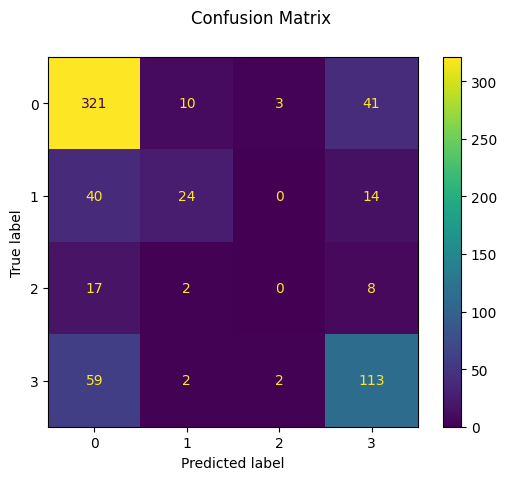

In [8]:
test_dataset = MyDataset(image_dir, test_data, 'test')
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    preds = []
    truth = []
    pbar = tqdm(test_dataloader, desc=f'Predicting')
    for images, multi_labels in pbar:
        images = images.to(DEVICE)
        multi_labels = multi_labels.to(DEVICE)
        multi_outputs = model(images)
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()
        

# all
print(classification_report(truth, preds))
disp = ConfusionMatrixDisplay.from_predictions(truth, preds)
disp.figure_.suptitle("Confusion Matrix")

Predicting: 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       139
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.85      0.66      0.74        83

    accuracy                           0.79       222
   macro avg       0.42      0.38      0.40       222
weighted avg       0.83      0.79      0.81       222



Text(0.5, 0.98, 'Confusion Matrix')

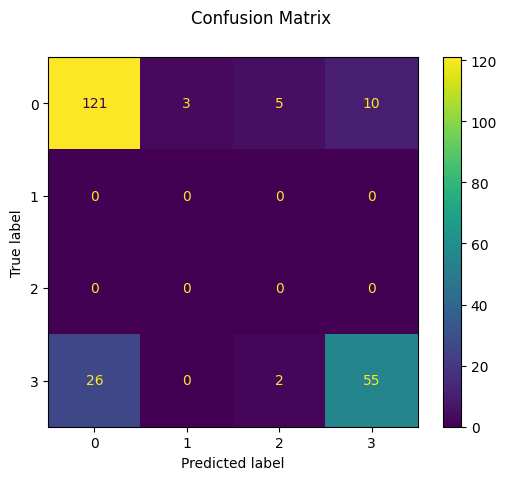

In [9]:
test_dataset = MyDataset(image_dir, test_data, 'test', 'mono')
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    preds = []
    truth = []
    pbar = tqdm(test_dataloader, desc=f'Predicting')
    for images, multi_labels in pbar:
        images = images.to(DEVICE)
        multi_labels = multi_labels.to(DEVICE)
        multi_outputs = model(images)
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()
    

# mono
print(classification_report(truth, preds))
disp = ConfusionMatrixDisplay.from_predictions(truth, preds)
disp.figure_.suptitle("Confusion Matrix")

Predicting: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


              precision    recall  f1-score   support

           0       0.86      0.85      0.86       236
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.66      0.62      0.64        93

    accuracy                           0.79       329
   macro avg       0.38      0.37      0.37       329
weighted avg       0.80      0.79      0.79       329



Text(0.5, 0.98, 'Confusion Matrix')

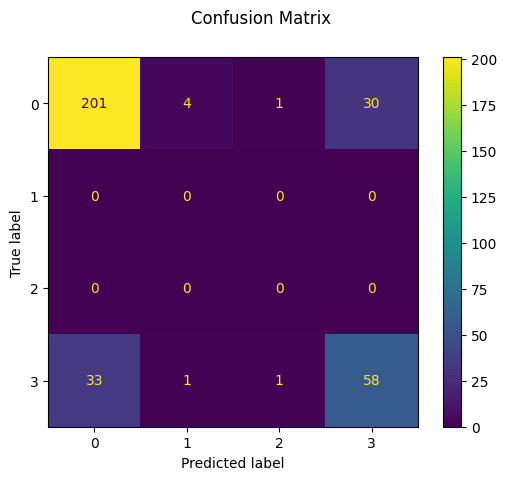

In [10]:
test_dataset = MyDataset(image_dir, test_data, 'test', 'poly')
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    preds = []
    truth = []
    pbar = tqdm(test_dataloader, desc=f'Predicting')
    for images, multi_labels in pbar:
        images = images.to(DEVICE)
        multi_labels = multi_labels.to(DEVICE)
        multi_outputs = model(images)
        multi_preds = torch.argmax(multi_outputs, dim=-1)
        preds += multi_preds.reshape(-1).tolist()
        truth += multi_labels.reshape(-1).tolist()
        

# poly
print(classification_report(truth, preds))
disp = ConfusionMatrixDisplay.from_predictions(truth, preds)
disp.figure_.suptitle("Confusion Matrix")